In [1]:
from torch.utils.data import DataLoader, Dataset, ConcatDataset
import torchvision.transforms as transforms
import random
from sklearn.model_selection import train_test_split
import os
import torch
import torch.nn as nn
import torch.optim as optim
import tifffile as tiff
import torchvision
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm


In [2]:
# Set seed for reproducibility
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Set seed
set_seed(42)

In [3]:
class LabeledImageDataset(Dataset):
    def __init__(self, image_files, labels, transform=None):
        self.image_files = image_files
        self.labels = labels
        self.transform = transform
        self.resize_transform = transforms.Resize((96, 96))

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = self.image_files[idx]
        image = tiff.imread(img_path)

        # Ensure the image has 3 layers (channels)
        if image.shape[0] != 3:
            raise ValueError(f"Image {img_path} does not have exactly 3 layers.")

        # Normalize the 16-bit image to [0, 1]
        image = image.astype(np.float32) / 65535.0

        # Convert to a torch tensor and add channel dimension
        image = torch.tensor(image, dtype=torch.float32)
        
        # Apply resize transform
        image = self.resize_transform(image)

        # Apply any provided transformations
        if self.transform is not None:
            image = self.transform(image)
        
        #image = self.transform_normalise(image)

        label = self.labels[idx]

        return image, label

In [4]:
def load_and_split_data(root_dir, test_size=0.2):
    classes = ['cond7_all', 'sd','ex']
    image_files = []
    labels = []

    for idx, class_name in enumerate(classes):
        class_dir = os.path.join(root_dir, class_name)
        files = [os.path.join(class_dir, file) for file in os.listdir(class_dir) if file.endswith(('.tiff', '.tif'))]
        image_files.extend(files)
        labels.extend([idx] * len(files))
    
    # Split data into training and test sets
    train_files, test_files, train_labels, test_labels = train_test_split(
        image_files, labels, test_size=test_size, stratify=labels, random_state=42)

    return train_files, test_files, train_labels, test_labels

In [5]:
train_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomResizedCrop(size=96, scale=(0.7, 1.0)),
    transforms.RandomAdjustSharpness(sharpness_factor=2.0, p=0.5),
    transforms.GaussianBlur(kernel_size=5, sigma=(0.1, 0.5)),
    transforms.RandomApply([
    transforms.ColorJitter(brightness=0.15, contrast=0.35)
    ], p=0.8)
])


# Directories for labeled data
image_dir = r"G:\classification\cond_all"

# Load and split the data
train_files, test_files, train_labels, test_labels = load_and_split_data(image_dir, test_size=0.2)

# Create the labeled datasets
train_labeled_dataset = LabeledImageDataset(train_files, train_labels)
test_labeled_dataset = LabeledImageDataset(test_files, test_labels)

# Define DataLoaders
batch_size = 16
train_loader = DataLoader(train_labeled_dataset, batch_size=batch_size, shuffle=True, drop_last=False, pin_memory=True, num_workers=0)
test_loader = DataLoader(test_labeled_dataset, batch_size=batch_size, shuffle=False, drop_last=False, pin_memory=True, num_workers=0)

In [6]:
# Directories for labeled data
image_dir = r"G:\classification\cond_all"

# Load and split the data
train_files, test_files, train_labels, test_labels = load_and_split_data(image_dir, test_size=0.2)

# Create the original training dataset without augmentations
train_labeled_dataset = LabeledImageDataset(train_files, train_labels, transform=None)


# Create augmented datasets by applying the transforms multiple times
augmentations_count = 2  # Number of augmentations to create per image

augmented_datasets = []
for _ in range(augmentations_count):
    augmented_dataset = LabeledImageDataset(train_files, train_labels, transform=train_transforms)
    augmented_datasets.append(augmented_dataset)

# Combine the original dataset with the augmented datasets
train_img_aug_data = ConcatDataset([train_labeled_dataset] + augmented_datasets)

# Create the test dataset without augmentations
test_img_data = LabeledImageDataset(test_files, test_labels, transform=None)

batch_size = 16

In [7]:
# Print the number of images in the training and test datasets
print(f"Number of training images: {len(train_files)}")
print(f"Number of test images: {len(test_files)}")

Number of training images: 492
Number of test images: 123


In [8]:
train_loader = DataLoader(train_img_aug_data, batch_size=batch_size, shuffle=True,
                                   drop_last=True, pin_memory=True, num_workers=0)  #num_workers=os.cpu_count()
test_loader = DataLoader(test_img_data, batch_size=batch_size, shuffle=False,
                                  drop_last=False, pin_memory=True, num_workers=0)

# Example loop to check the shapes of train and test data
def check_data_shapes(loader, dataset_name="Train"):
    for images, labels in loader:
        print(f"{dataset_name} - Image batch shape: {images.shape}, Label batch shape: {labels.shape}")
        break  # Print only for the first batch

# Checking the train data
check_data_shapes(train_loader, "Train")

# Checking the test data
check_data_shapes(test_loader, "Test")


total_images = 0

for images, _ in train_loader:
    total_images += images.size(0)  # images.size(0) gives the batch size

print(f"Total number of images in the train loader: {total_images}")


total_images = 0

for images, _ in test_loader:
    total_images += images.size(0)  # images.size(0) gives the batch size

print(f"Total number of images in the test loader: {total_images}")

In [9]:
class ResNet(nn.Module):

    def __init__(self, num_classes):
        super().__init__()
        # Load the pretrained ResNet18 model
        self.convnet = torchvision.models.resnet18(weights='ResNet18_Weights.DEFAULT')

        # Modify the fully connected layer to match the number of classes
        self.convnet.fc = nn.Linear(self.convnet.fc.in_features, num_classes)

    def forward(self, x):
        return self.convnet(x)

def train_epoch(model, dataloader, optimizer, criterion, device):
    model.train()
    epoch_loss = 0
    correct = 0
    total = 0

    for imgs, labels in dataloader:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        preds = model(imgs)
        loss = criterion(preds, labels)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        correct += (preds.argmax(dim=-1) == labels).sum().item()
        total += labels.size(0)

    accuracy = correct / total
    return epoch_loss / len(dataloader), accuracy

def evaluate_model(model, dataloader, criterion, device):
    model.eval()
    epoch_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for imgs, labels in dataloader:
            imgs, labels = imgs.to(device), labels.to(device)
            preds = model(imgs)
            loss = criterion(preds, labels)

            epoch_loss += loss.item()
            correct += (preds.argmax(dim=-1) == labels).sum().item()
            total += labels.size(0)

    accuracy = correct / total
    return epoch_loss / len(dataloader), accuracy

In [10]:
def train_resnet(batch_size, max_epochs=100, **kwargs):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = ResNet(**kwargs).to(device)
    optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=2e-4)
    criterion = nn.CrossEntropyLoss()

    lr_scheduler = optim.lr_scheduler.MultiStepLR(optimizer,
                                                  milestones=[int(max_epochs * 0.7), int(max_epochs * 0.9)],
                                                  gamma=0.1)

    best_acc = 0.0
    best_model_path = os.path.join("ResNet_best_model.pth")

    # Lists to store loss and accuracy for each epoch
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []

    for epoch in range(max_epochs):
        train_loss, train_acc = train_epoch(model, train_loader, optimizer, criterion, device)
        val_loss, val_acc = evaluate_model(model, test_loader, criterion, device)

        lr_scheduler.step()

        # Store the results
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)

        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), best_model_path)

        print(f"Epoch {epoch + 1}/{max_epochs}, "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

    # Load the best model and evaluate it on the train and test sets
    model.load_state_dict(torch.load(best_model_path, weights_only=True))
    train_loss, train_acc = evaluate_model(model, train_loader, criterion, device)
    test_loss, test_acc = evaluate_model(model, test_loader, criterion, device)

    result = {"train": train_acc, "test": test_acc}

    # Plotting the loss and accuracy curves
    plt.figure(figsize=(14, 5))

    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Test Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Train vs. Test Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Train Accuracy')
    plt.plot(val_accuracies, label='Test Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Train vs. Test Accuracy')
    plt.legend()

    plt.show()

    return model, result

Epoch 1/10, Train Loss: 0.2148, Train Acc: 0.9348, Val Loss: 0.1741, Val Acc: 0.9268
Epoch 2/10, Train Loss: 0.1331, Train Acc: 0.9647, Val Loss: 0.5107, Val Acc: 0.7886
Epoch 3/10, Train Loss: 0.1314, Train Acc: 0.9579, Val Loss: 1.1163, Val Acc: 0.7073
Epoch 4/10, Train Loss: 0.1139, Train Acc: 0.9592, Val Loss: 0.1482, Val Acc: 0.9187
Epoch 5/10, Train Loss: 0.1172, Train Acc: 0.9640, Val Loss: 0.3621, Val Acc: 0.8374
Epoch 6/10, Train Loss: 0.0433, Train Acc: 0.9851, Val Loss: 0.0112, Val Acc: 0.9919
Epoch 7/10, Train Loss: 0.1175, Train Acc: 0.9640, Val Loss: 0.3021, Val Acc: 0.8618
Epoch 8/10, Train Loss: 0.0539, Train Acc: 0.9830, Val Loss: 0.0026, Val Acc: 1.0000
Epoch 9/10, Train Loss: 0.0262, Train Acc: 0.9905, Val Loss: 0.0017, Val Acc: 1.0000
Epoch 10/10, Train Loss: 0.0381, Train Acc: 0.9885, Val Loss: 0.0026, Val Acc: 1.0000


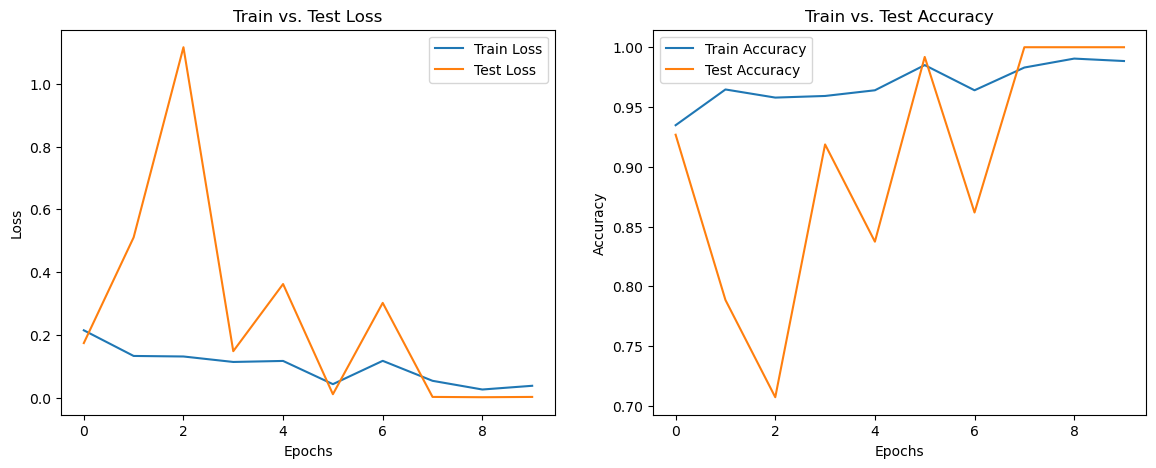

Accuracy on training set: 99.73%
Accuracy on test set: 100.00%


In [13]:
resnet_model, resnet_result = train_resnet(batch_size=16,
                                           num_classes=3,
                                           max_epochs=10)
print(f"Accuracy on training set: {100 * resnet_result['train']:4.2f}%")
print(f"Accuracy on test set: {100 * resnet_result['test']:4.2f}%")